<a href="https://colab.research.google.com/github/agshiv92/PlaygroundS4E03-EDA-Submission/blob/main/PlaygroundS4E03%7CEDA%7CSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1.0 Introduction 💥
**Welcome to this notebook, where we will do the EDA analysis and Prediction and Submission in Beginner Friendly manner. This competition is abount prediction of person able to quit smoking or not based on the various test and paramerts available

> **This notebook that is profoundly explained for beginners starting on Kaggle**.!

![smoking.png](attachment:fe038839-037b-4195-89e4-b9d68369e020.png)

# 2.0 Install Libraries 🛠

Not downloading any special library for this competition

In [34]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=949430efff4df30dc68d7996ffa564a0affdafc8bec487a51c6847b935e9360b
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


# 3.0 Import Libraries 📚

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as ww
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import plotly.graph_objs as go
import warnings
import plotly.express as px
import zipfile
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ww.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='viridis')
import joblib
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sns.set(style="whitegrid")

# 3.0 Configuration ⚙️

### 3.1 Models and Parameters for Optimization

In [86]:

class CFG:# models to optimize
    models = {
        'LogisticRegressionCV': LogisticRegressionCV( solver='lbfgs', max_iter=1000),
        'RandomForestClassifier': RandomForestClassifier(),
        'XGBClassifier': XGBClassifier()
    }
    # define the hyperparameter grid for each model
    param_grids = {
    'LogisticRegressionCV': {"Cs": [0.1, 1, 10]},
    'RandomForestClassifier': {"n_estimators": [50,100,200], "max_depth": [None, 10, 20]},
    'XGBClassifier': {"learning_rate": [0.1, 0.01, 0.001], "max_depth": [3,5,7]}
    }
    # defining the parameters for fixing the colors, scale and axis
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--',
                           'color': 'lightgrey', 'linewidth': 0.75}
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': '#992600'}
    additional_columns_to_remove = ['id']
    download = True
    dirname = '/content'
    competition = 'playground-series-s4e3.zip'
    extract_to_dir = '/content'
    custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
target_classes = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

In [79]:
CFG.models.items

<function dict.items>

### 3.2 Helper Functions

In [5]:
# Defining some important function which will be used for the analysis of data
def inspect_columns(df):
    """A helper function that does a better job than df.info() and df.describe()"""

    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,

    })

    return result

def categorize_columns(train, target_variable):
    numerical_data_types = ['int64', 'float64', 'datetime64[ns]']  # adjusted data types
    categorical_data_types = ['object']

    numerical_columns = [column for column in train.columns if train[column].dtype in numerical_data_types]
    print(f"Numerical variables ({len(numerical_columns)}): {numerical_columns}")

    categorical_columns = [column for column in train.columns if train[column].dtype in categorical_data_types]

    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    print(f"Categorical variables ({len(categorical_columns)}): {categorical_columns}")

    return numerical_columns, categorical_columns

# 4.0 Dataset Loading 📁

### 4.1 Data laoding 📁

In [139]:
if CFG.download:
    from google.colab import userdata
    os.environ["KAGGLE_KEY"] = userdata.get('key')
    os.environ["KAGGLE_USERNAME"] = userdata.get('username')
    !kaggle competitions download -c playground-series-s4e3
    dirname = CFG.dirname
    competition = CFG.competition
    zip_path = os.path.join(dirname,competition)

    extract_to_dir = CFG.extract_to_dir
    dirname = extract_to_dir
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
        zip_ref.extractall(extract_to_dir)

playground-series-s4e3.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
train = pd.read_csv(os.path.join(dirname, ('train'+'.csv')))
test = pd.read_csv(os.path.join(dirname, ('test'+'.csv')))

### 4.2 Meta Data 📖

- `Age` - 5-years gap
- `Height (cm)`
- `Weight (kg)`
- `Waist (cm)` - Waist circumference length
- `Eyesight (left)`
- `Eyesight (right)`
- `Hearing (left)`
- `Hearing (right)`
- `Systolic` - Blood pressure
- `Relaxation` - Blood pressure
- `Fasting blood sugar`
- `Cholesterol` - Total
- `Triglyceride`
- `HDL` - Cholesterol type
- `LDL` - Cholesterol type
- `Hemoglobin`
- `Urine protein`
- `Serum creatinine`
- `AST` - Glutamic oxaloacetic transaminase type
- `ALT` - Glutamic oxaloacetic transaminase type
- `GTP` - γ-GTP
- `Dental caries`
- `Smoking`

### 4.3 Overview of Data 📊

In [8]:
from IPython.display import display
print("Training Data: Top 5 Rows")
display(train.head())
print('-' * 150)
print("Test Data: Top 5 Rows")
display(test.head())

Training Data: Top 5 Rows


id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0   0        584        590     909972     909977            16            8   
1   1        808        816     728350     728372           433           20   
2   2         39        192    2212076    2212144         11388          705   
3   3        781        789    3353146    3353173           210           16   
4   4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  ...  \
0            5               2274                    113  ...   
1           54              44478                     70  ...   
2          420            1311391                     29  ...   
3           29               3202                    114  ...   
4           67              48231                     82  ...   

   Orientation_Index  Luminosity_Index  SigmoidOfAreas  Pastry  Z_Scratch  \
0            -0.5000           -0.0104          0.1417       0          0   
1             0.7419           -0.2997          0.9491       0          0   
2            -0.0105           -0.0944          1.0000       0          0   
3             0.6667           -0.0402          0.4025       0          0   
4             0.9158           -0.2455          0.9998       0          0   

   K_Scatch  Stains  Dirtiness  Bumps  Other_Faults  
0         0       1          0      0             0  
1         0       0          0      0             1  
2         1       0          0      0             0  
3         1       0          0      0             0  
4         0       0          0      0             1  

[5 rows x 35 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------
Test Data: Top 5 Rows


id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0  19219       1015       1033    3826564    3826588           659   
1  19220       1257       1271     419960     419973           370   
2  19221       1358       1372     117715     117724           289   
3  19222        158        168     232415     232440            80   
4  19223        559        592     544375     544389           140   

   X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  ...  \
0           23           46              62357                     67  ...   
1           26           28              39293                     92  ...   
2           36           32              29386                    101  ...   
3           10           11               8586                    107  ...   
4           19           15              15524                    103  ...   

   Outside_X_Index  Edges_X_Index  Edges_Y_Index  Outside_Global_Index  \
0           0.0095         0.5652         1.0000                   1.0   
1           0.0047         0.2414         1.0000                   1.0   
2           0.0155         0.6000         0.7500                   0.0   
3           0.0037         0.8000         1.0000                   1.0   
4           0.0158         0.8421         0.5333                   0.0   

   LogOfAreas  Log_X_Index  Log_Y_Index  Orientation_Index  Luminosity_Index  \
0      2.8410       1.1139       1.6628             0.6727           -0.2261   
1      2.5682       0.9031       1.4472             0.9063           -0.1453   
2      2.4609       1.3222       1.3222            -0.5238           -0.0435   
3      1.9031       0.6990       1.0414             0.1818           -0.0738   
4      2.1461       1.3222       1.1461            -0.5714           -0.0894   

   SigmoidOfAreas  
0          0.9172  
1          0.9104  
2          0.6514  
3          0.2051  
4          0.4170  

[5 rows x 28 columns]

### 4.4 Dataset Health Checkup 🩺

In [9]:
print("Training Data Health Checkup")
display(inspect_columns(train))
print('-' * 150)
print("Test Data Health Checkup")
display(inspect_columns(test))
print('-' * 150)

Training Data Health Checkup


total_rows  rows_with_missing_values  unique  \
id                          19219                         0    True   
X_Minimum                   19219                         0   False   
X_Maximum                   19219                         0   False   
Y_Minimum                   19219                         0   False   
Y_Maximum                   19219                         0   False   
Pixels_Areas                19219                         0   False   
X_Perimeter                 19219                         0   False   
Y_Perimeter                 19219                         0   False   
Sum_of_Luminosity           19219                         0   False   
Minimum_of_Luminosity       19219                         0   False   
Maximum_of_Luminosity       19219                         0   False   
Length_of_Conveyer          19219                         0   False   
TypeOfSteel_A300            19219                         0   False   
TypeOfSteel_A400            19219                         0   False   
Steel_Plate_Thickness       19219                         0   False   
Edges_Index                 19219                         0   False   
Empty_Index                 19219                         0   False   
Square_Index                19219                         0   False   
Outside_X_Index             19219                         0   False   
Edges_X_Index               19219                         0   False   
Edges_Y_Index               19219                         0   False   
Outside_Global_Index        19219                         0   False   
LogOfAreas                  19219                         0   False   
Log_X_Index                 19219                         0   False   
Log_Y_Index                 19219                         0   False   
Orientation_Index           19219                         0   False   
Luminosity_Index            19219                         0   False   
SigmoidOfAreas              19219                         0   False   
Pastry                      19219                         0   False   
Z_Scratch                   19219                         0   False   
K_Scatch                    19219                         0   False   
Stains                      19219                         0   False   
Dirtiness                   19219                         0   False   
Bumps                       19219                         0   False   
Other_Faults                19219                         0   False   

                       cardinality  with_null  null_pct      1st_row  \
id                           19219      False       0.0       0.0000   
X_Minimum                     1191      False       0.0     584.0000   
X_Maximum                     1259      False       0.0     590.0000   
Y_Minimum                     3345      False       0.0  909972.0000   
Y_Maximum                     3341      False       0.0  909977.0000   
Pixels_Areas                  1154      False       0.0      16.0000   
X_Perimeter                    460      False       0.0       8.0000   
Y_Perimeter                    331      False       0.0       5.0000   
Sum_of_Luminosity             2595      False       0.0    2274.0000   
Minimum_of_Luminosity          162      False       0.0     113.0000   
Maximum_of_Luminosity           98      False       0.0     140.0000   
Length_of_Conveyer              99      False       0.0    1358.0000   
TypeOfSteel_A300                 2      False       0.0       0.0000   
TypeOfSteel_A400                 2      False       0.0       1.0000   
Steel_Plate_Thickness           27      False       0.0      50.0000   
Edges_Index                   1849      False       0.0       0.7393   
Empty_Index                   1748      False       0.0       0.4000   
Square_Index                  1118      False       0.0       0.5000   
Outside_X_Index                525      False       0.0       0.0059   
Edges_X_Index             

------------------------------------------------------------------------------------------------------------------------------------------------------
Test Data Health Checkup


total_rows  rows_with_missing_values  unique  \
id                          12814                         0    True   
X_Minimum                   12814                         0   False   
X_Maximum                   12814                         0   False   
Y_Minimum                   12814                         0   False   
Y_Maximum                   12814                         0   False   
Pixels_Areas                12814                         0   False   
X_Perimeter                 12814                         0   False   
Y_Perimeter                 12814                         0   False   
Sum_of_Luminosity           12814                         0   False   
Minimum_of_Luminosity       12814                         0   False   
Maximum_of_Luminosity       12814                         0   False   
Length_of_Conveyer          12814                         0   False   
TypeOfSteel_A300            12814                         0   False   
TypeOfSteel_A400            12814                         0   False   
Steel_Plate_Thickness       12814                         0   False   
Edges_Index                 12814                         0   False   
Empty_Index                 12814                         0   False   
Square_Index                12814                         0   False   
Outside_X_Index             12814                         0   False   
Edges_X_Index               12814                         0   False   
Edges_Y_Index               12814                         0   False   
Outside_Global_Index        12814                         0   False   
LogOfAreas                  12814                         0   False   
Log_X_Index                 12814                         0   False   
Log_Y_Index                 12814                         0   False   
Orientation_Index           12814                         0   False   
Luminosity_Index            12814                         0   False   
SigmoidOfAreas              12814                         0   False   

                       cardinality  with_null  null_pct       1st_row  \
id                           12814      False       0.0  1.921900e+04   
X_Minimum                     1131      False       0.0  1.015000e+03   
X_Maximum                     1188      False       0.0  1.033000e+03   
Y_Minimum                     2781      False       0.0  3.826564e+06   
Y_Maximum                     2827      False       0.0  3.826588e+06   
Pixels_Areas                  1070      False       0.0  6.590000e+02   
X_Perimeter                    435      False       0.0  2.300000e+01   
Y_Perimeter                    316      False       0.0  4.600000e+01   
Sum_of_Luminosity             2300      False       0.0  6.235700e+04   
Minimum_of_Luminosity          161      False       0.0  6.700000e+01   
Maximum_of_Luminosity           99      False       0.0  1.270000e+02   
Length_of_Conveyer              92      False       0.0  1.656000e+03   
TypeOfSteel_A300                 2      False       0.0  0.000000e+00   
TypeOfSteel_A400                 2      False       0.0  1.000000e+00   
Steel_Plate_Thickness           24      False       0.0  1.500000e+02   
Edges_Index                   1697      False       0.0  3.877000e-01   
Empty_Index                   1606      False       0.0  4.896000e-01   
Square_Index                   987      False       0.0  3.273000e-01   
Outside_X_Index                480      False       0.0  9.500000e-03   
Edges_X_Index                  998      False       0.0  5.652000e-01   
Edges_Y_Index                  788      False       0.0  1.000000e+00   
Outside_Global_Index             3      False       0.0  1.000000e+00   
LogOfAreas                     994      False       0.0  2.841000e+00   
Log_X_Index                    189      False       0.0  1.113900e+00   
Log_Y_Index                    218      False       0.0  1.662800e+00   
Orientation_Index             1382      False       0.0  6.727000

------------------------------------------------------------------------------------------------------------------------------------------------------


### 4.5 Summary Statistic

In [10]:
target = train[target_classes]
train = train.drop(target_classes, axis="columns")
train = train.drop(CFG.additional_columns_to_remove, axis="columns")
features = train.columns
features = features.tolist()

train[features].describe().T.round(1)

count       mean        std     min       25%  \
X_Minimum              19219.0      709.9      531.5     0.0      49.0   
X_Maximum              19219.0      753.9      499.8     4.0     214.0   
Y_Minimum              19219.0  1849756.0  1903553.9  6712.0  657468.0   
Y_Maximum              19219.0  1846605.3  1896295.1  6724.0  657502.0   
Pixels_Areas           19219.0     1684.0     3730.3     6.0      89.0   
X_Perimeter            19219.0       95.7      177.8     2.0      15.0   
Y_Perimeter            19219.0       64.1      101.1     1.0      14.0   
Sum_of_Luminosity      19219.0   191846.7   442024.7   250.0    9848.0   
Minimum_of_Luminosity  19219.0       84.8       28.8     0.0      70.0   
Maximum_of_Luminosity  19219.0      128.6       14.2    39.0     124.0   
Length_of_Conveyer     19219.0     1459.4      145.6  1227.0    1358.0   
TypeOfSteel_A300       19219.0        0.4        0.5     0.0       0.0   
TypeOfSteel_A400       19219.0        0.6        0.5     0.0       0.0   
Steel_Plate_Thickness  19219.0       76.2       53.9    40.0      40.0   
Edges_Index            19219.0        0.4        0.3     0.0       0.1   
Empty_Index            19219.0        0.4        0.1     0.0       0.3   
Square_Index           19219.0        0.6        0.3     0.0       0.4   
Outside_X_Index        19219.0        0.0        0.0     0.0       0.0   
Edges_X_Index          19219.0        0.6        0.2     0.0       0.5   
Edges_Y_Index          19219.0        0.8        0.2     0.1       0.7   
Outside_Global_Index   19219.0        0.6        0.5     0.0       0.0   
LogOfAreas             19219.0        2.5        0.8     0.8       1.9   
Log_X_Index            19219.0        1.3        0.5     0.3       1.0   
Log_Y_Index            19219.0        1.4        0.4     0.0       1.1   
Orientation_Index      19219.0        0.1        0.5    -1.0      -0.3   
Luminosity_Index       19219.0       -0.1        0.1    -0.9      -0.2   
SigmoidOfAreas         19219.0        0.6        0.3     0.1       0.3   

                             50%        75%         max  
X_Minimum                  777.0     1152.0      1705.0  
X_Maximum                  796.0     1165.0      1713.0  
Y_Minimum              1398169.0  2368032.0  12987661.0  
Y_Maximum              1398179.0  2362511.0  12987692.0  
Pixels_Areas               168.0      653.0    152655.0  
X_Perimeter                 25.0       64.0      7553.0  
Y_Perimeter                 23.0       61.0       903.0  
Sum_of_Luminosity        18238.0    67978.0  11591414.0  
Minimum_of_Luminosity       90.0      105.0       196.0  
Maximum_of_Luminosity      127.0      135.0       253.0  
Length_of_Conveyer        1364.0     1652.0      1794.0  
TypeOfSteel_A300             0.0        1.0         1.0  
TypeOfSteel_A400             1.0        1.0         1.0  
Steel_Plate_Thickness       69.0       80.0       300.0  
Edges_Index                  0.2        0.7         1.0  
Empty_Index                  0.4        0.5         0.9  
Square_Index                 0.5        0.8         1.0  
Outside_X_Index              0.0        0.0         0.7  
Edges_X_Index                0.6        0.8         1.0  
Edges_Y_Index                1.0        1.0         1.0  
Outside_Global_Index         1.0        1.0         1.0  
LogOfAreas                   2.2        2.8         4.6  
Log_X_Index                  1.1        1.4         3.0  
Log_Y_Index                  1.3        1.7         4.0  
Orientation_Index            0.1        0.5         1.0  
Luminosity_Index            -0.1       -0.1         0.6  
SigmoidOfAreas               0.5        1.0         1.0

# 5.0 Exploratory Data Analysis 🔍

In [11]:
numerical_col = [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and train[col].nunique() > 18]
categorical_col = [col for col in train.columns if train[col].dtype == 'object' or train[col].dtype.name == 'category' or (train[col].dtype in ['int64', 'float64'] and train[col].nunique() < 19)]
print("Numerical columns in the dataset:", numerical_col)
print("\nCategorical columns in the dataset:", categorical_col)

Numerical columns in the dataset: ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

Categorical columns in the dataset: ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']


### 5.1 Numerical Pair Plots

In [12]:
target['target'] = target.idxmax(axis=1)
target['target'] = 0
target.loc[target['Other_Faults'] == 1, 'target'] = 'Other_Faults'
target.loc[target['Bumps'] == 1, 'target'] = 'Bumps'
target.loc[target['Dirtiness'] == 1, 'target'] = 'Dirtiness'
target.loc[target['Stains'] == 1, 'target'] = 'Stains'
target.loc[target['K_Scatch'] == 1, 'target'] = 'K_Scatch'
target.loc[target['Z_Scratch'] == 1, 'target'] = 'Z_Scratch'
target.loc[target['Pastry'] == 1, 'target'] = 'Pastry'
target.loc[target['target'] == 0, 'target'] = 'No Defect'

<Figure size 1800x1000 with 0 Axes>

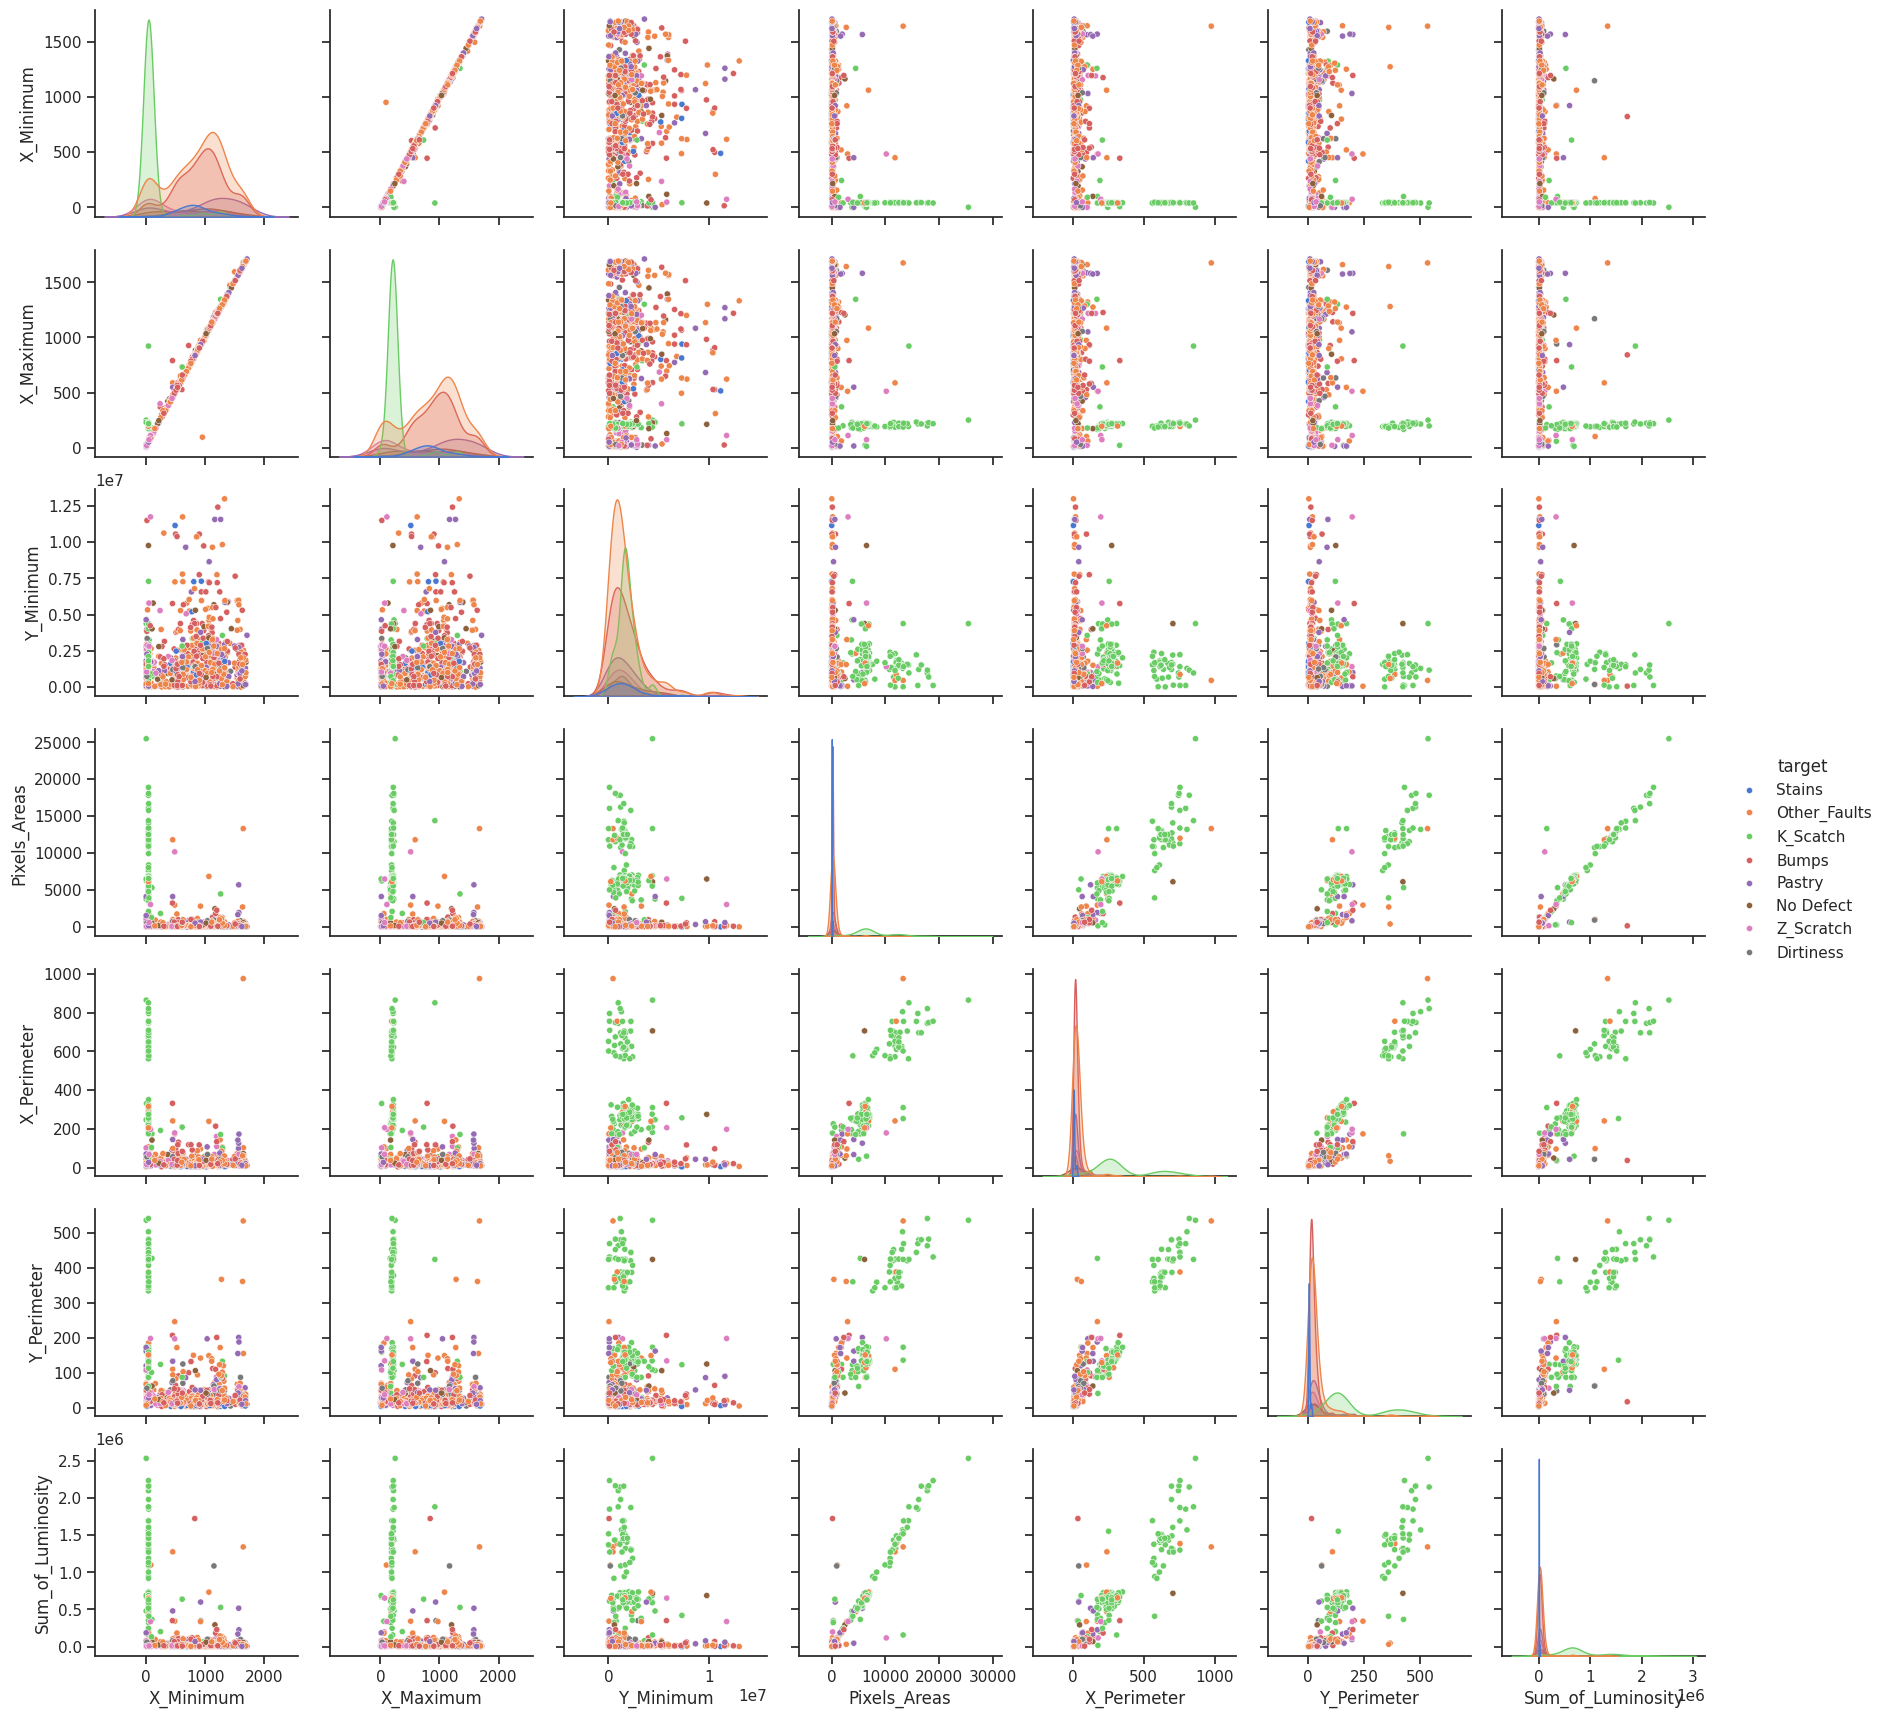

In [13]:
train_small = train.head(1000)
train_small['target']= target['target'].head(1000)
pair_plot_vars = ['X_Minimum', 'X_Maximum', 'Y_Minimum','Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity']
sns.set(font_scale=1)
plt.figure(figsize=(18, 10))
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=train_small, vars=pair_plot_vars ,diag_kind='kde',
        kind='scatter', palette='muted',
        plot_kws={'s': 20}, hue='target')
plt.show()

### 5.2 Distribution Plots

In [14]:
num_cols = 3  # You can adjust this based on how many columns you want per row
num_rows = -(-len(numerical_col) // num_cols)  # Ceiling division to get the minimum number of rows needed

# Creating subplots with dynamic subplot titles
fig = make_subplots(
    rows=num_rows, cols=num_cols,
    subplot_titles=[f"{col.replace('_', ' ').title()} Distribution" for col in numerical_col])
uniform_color = 'blue'
# Loop through the numerical columns and add a trace for each
for i, col in enumerate(numerical_col, start=1):
    row = (i - 1) // num_cols + 1
    col_pos = (i - 1) % num_cols + 1

    fig.add_trace(
        go.Histogram(x=train[col], nbinsx=30, name=col.replace('_', ' ').title(), marker_color=uniform_color),
        row=row, col=col_pos
    )

# Updating layout for better readability
fig.update_layout(
    height=400 * num_rows,  # Adjust the height based on the number of rows
    width=1500,
    title_text="Distributions of Key Health Indicators",
    bargap=0.1,
    showlegend=False
)

# Show figure
fig.show()

### 5.3 Correlation Matrix

In [15]:
import plotly.figure_factory as ff
# Generating a correlation matrix heatmap using Plotly
corr_matrix = train.corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    colorscale='Viridis',
    showscale=True)

# Updating layout
fig.update_layout(height=1200, width=1400, title_text="Correlation Matrix with Annotations", margin=dict(t=100, l=300))

# Show figure
fig.show()

### 5.4 Categorical Features Analysis

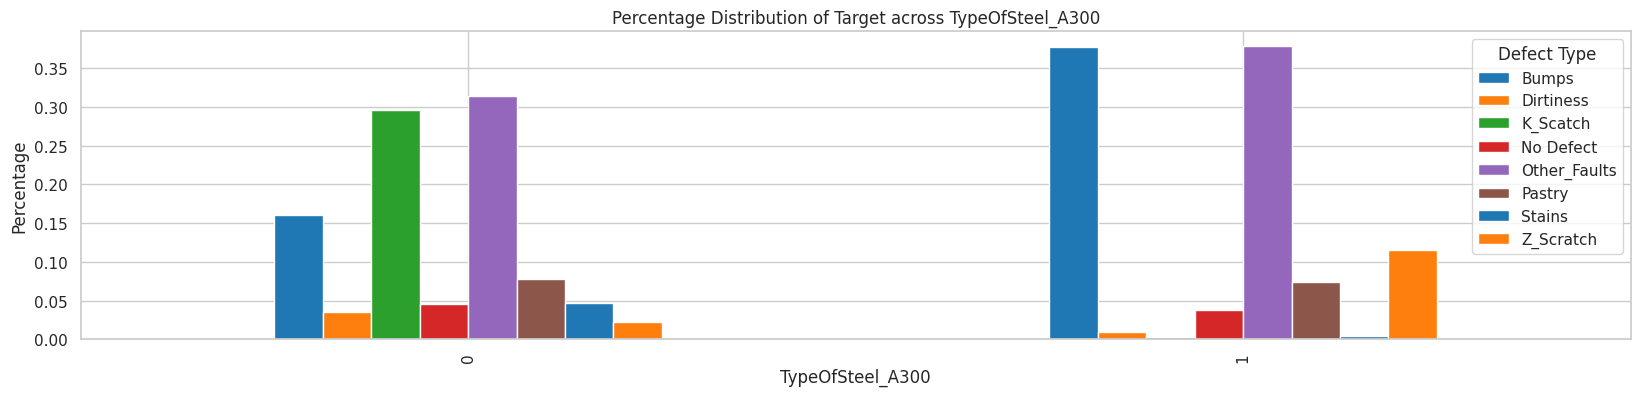

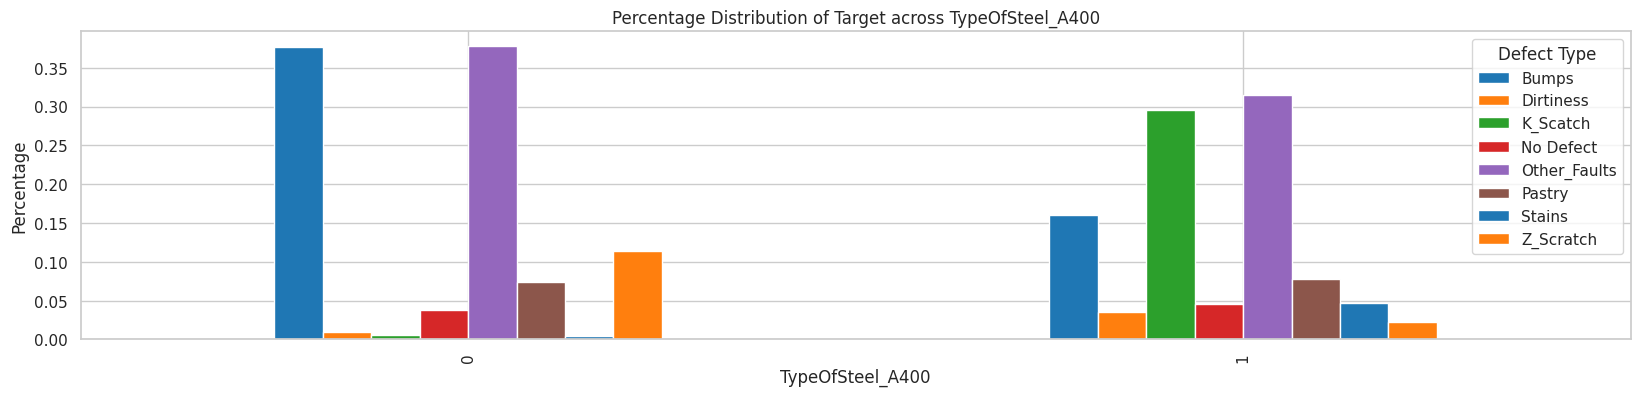

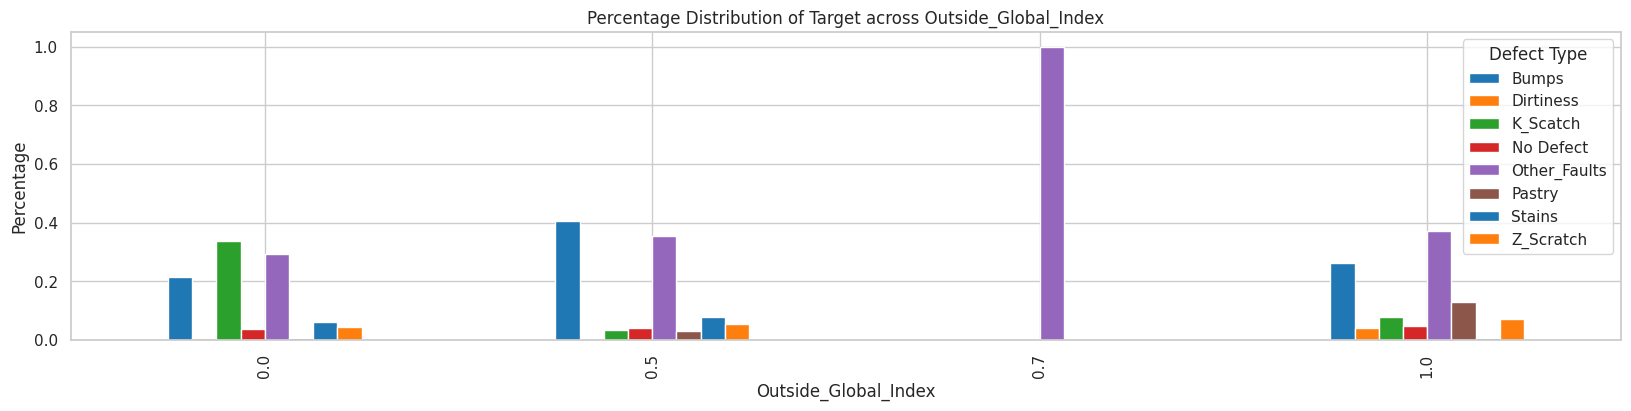

In [24]:
for col in categorical_col:
    train['target'] = target['target']
    contingency_table = pd.crosstab(train[col], train['target'], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=False, color=CFG.custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Defect Type")
    plt.show()


### 5.5 Relationshipt between Two Variables

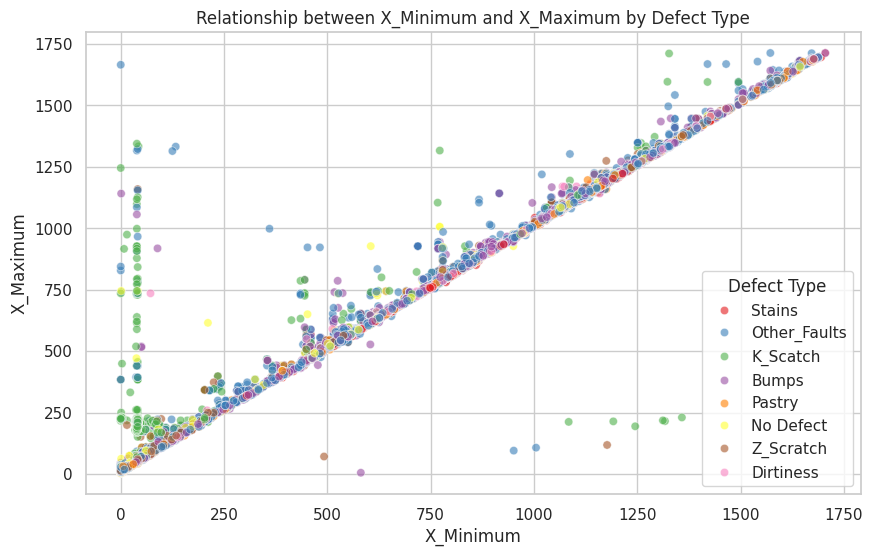

In [30]:
x = 'X_Minimum'
y = 'X_Maximum'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x=x, y=y, hue='target', palette='Set1', alpha=0.6)
plt.title(f'Relationship between {x} and {y} by Defect Type')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Defect Type')
plt.show()

In [26]:
train.head()

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0        584        590     909972     909977            16            8   
1        808        816     728350     728372           433           20   
2         39        192    2212076    2212144         11388          705   
3        781        789    3353146    3353173           210           16   
4       1540       1560     618457     618502           521           72   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0            5               2274                    113   
1           54              44478                     70   
2          420            1311391                     29   
3           29               3202                    114   
4           67              48231                     82   

   Maximum_of_Luminosity  ...  Edges_X_Index  Edges_Y_Index  \
0                    140  ...         1.0000         1.0000   
1                    111  ...         0.2500         1.0000   
2                    141  ...         0.2363         0.3857   
3                    134  ...         0.3750         0.9310   
4                    111  ...         0.2105         0.9861   

   Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                   0.0      1.2041       0.9031       0.6990   
1                   1.0      2.6365       0.7782       1.7324   
2                   0.0      4.0564       2.1790       2.2095   
3                   1.0      2.3222       0.7782       1.4314   
4                   1.0      2.7694       1.4150       1.8808   

   Orientation_Index  Luminosity_Index  SigmoidOfAreas        target  
0            -0.5000           -0.0104          0.1417        Stains  
1             0.7419           -0.2997          0.9491  Other_Faults  
2            -0.0105           -0.0944          1.0000      K_Scatch  
3             0.6667           -0.0402          0.4025      K_Scatch  
4             0.9158           -0.2455          0.9998  Other_Faults  

[5 rows x 28 columns]

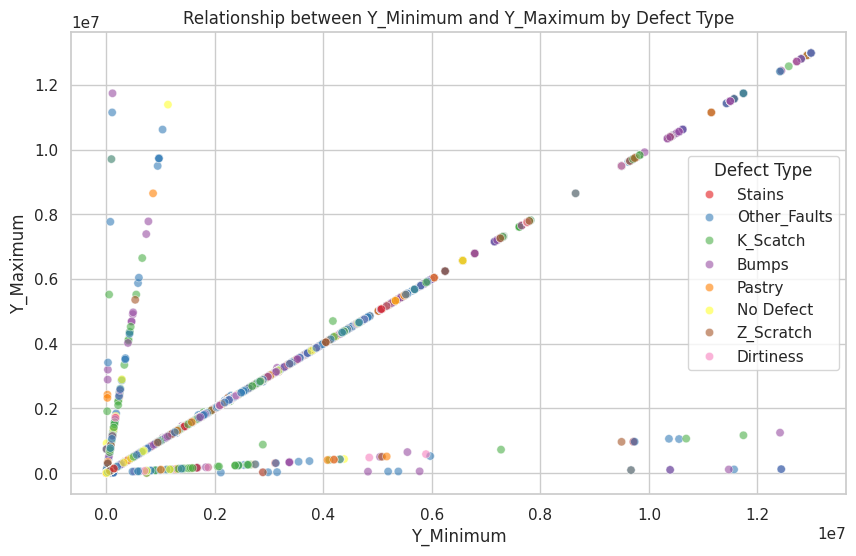

In [31]:

x = 'Y_Minimum'
y = 'Y_Maximum'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x=x, y=y, hue='target', palette='Set1', alpha=0.6)
plt.title(f'Relationship between {x} and {y} by Defect Type')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Defect Type')
plt.show()

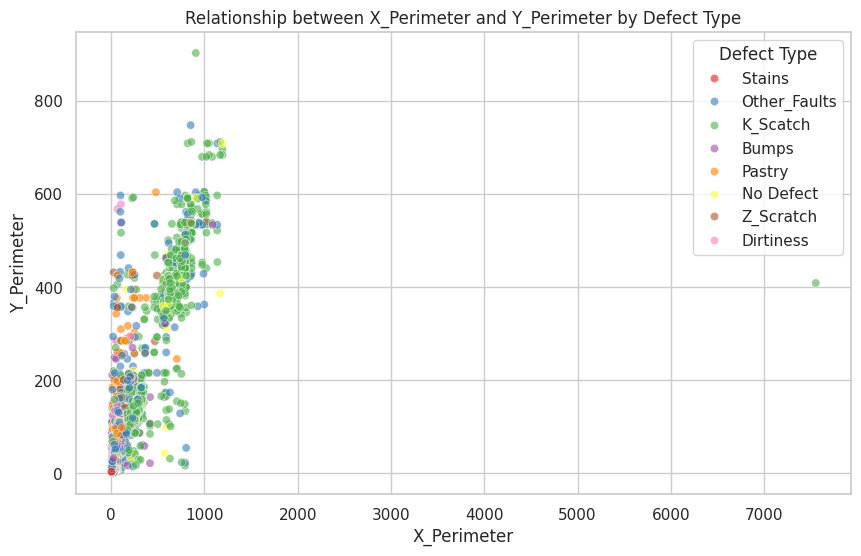

In [32]:


x = 'X_Perimeter'
y = 'Y_Perimeter'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x=x, y=y, hue='target', palette='Set1', alpha=0.6)
plt.title(f'Relationship between {x} and {y} by Defect Type')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Defect Type')
plt.show()

### 5.6 PCA and UMAP Plot

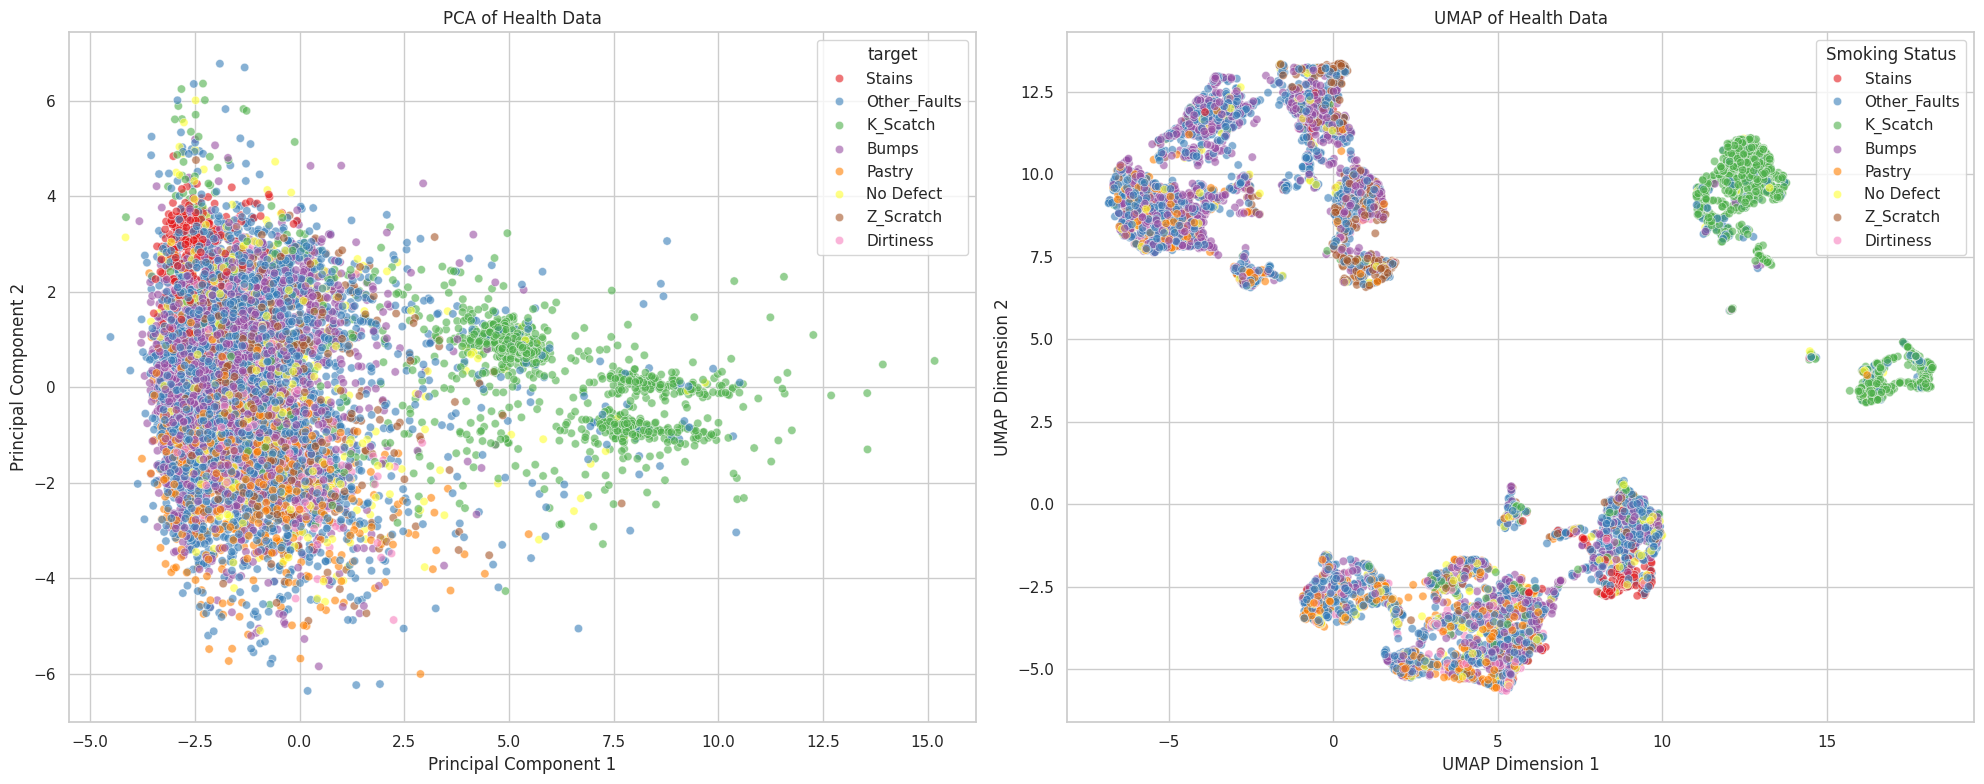

In [35]:
from sklearn.preprocessing import StandardScaler
from umap.umap_ import UMAP
from sklearn.decomposition import PCA
train_small = train.head(10000)
train_small['target']= target['target'].head(10000)
# Preparing the data for PCA and UMAP by dropping non-numeric and target columns
X = train_small.drop(['target'], axis=1)
y = train_small['target']

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Applying UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# Plotting PCA results
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('PCA of Health Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plotting UMAP results
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('UMAP of Health Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Smoking Status')
plt.tight_layout()
plt.show()

### 5.7 Test and Train dataset comparison

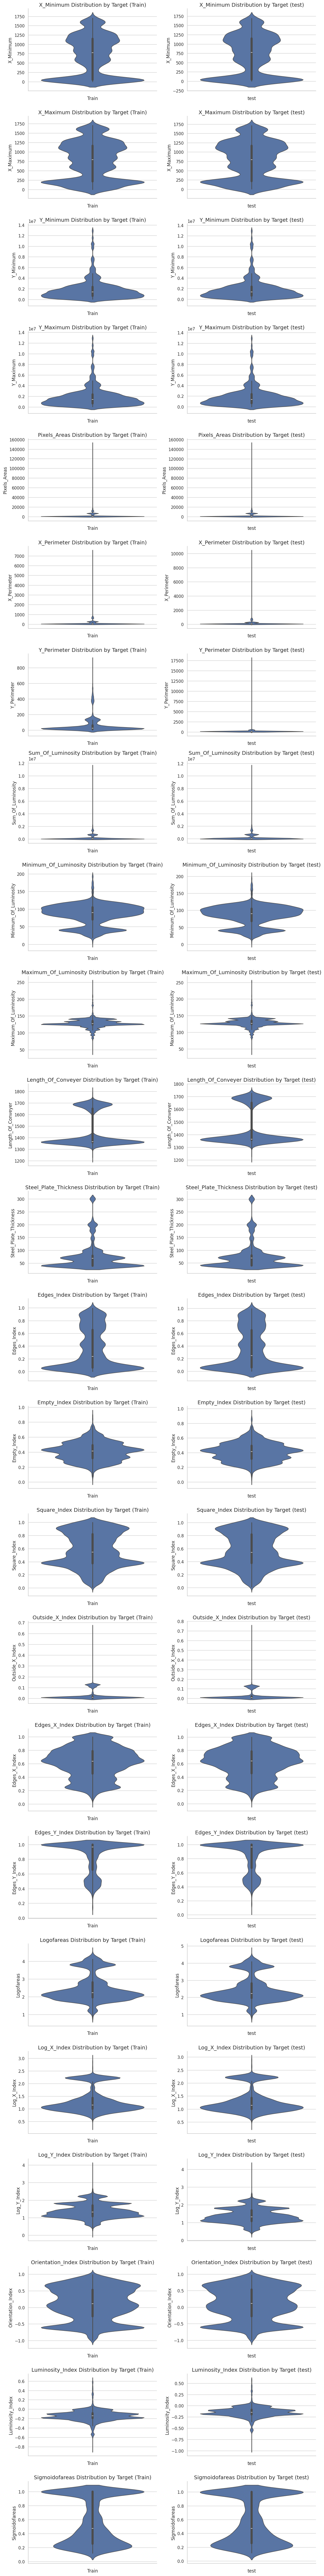

In [36]:
n_rows = len(numerical_col)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set3")
for i, col in enumerate(numerical_col):
    sns.violinplot(y=col, data=train, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('Train', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot( y=col, data=test, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (test)', fontsize=14)
    axs[i, 1].set_xlabel('test', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

# 6.0 Feature Engineering 🪄

### 6.1 Missing Data Handling

The data does not have any missing data so missing data handling is required

### 6.2 Outlier Handling

TBC

### 6.3 New Feature Creations

In [ ]:
def feature_engineering(df):
    """
    Apply feature engineering to the dataset.
    Parameters:
    df (DataFrame): The input dataframe containing health data.
    Returns:
    DataFrame: The dataframe with new features.
    """
    'TBC'

    return df


### 6.4 Statistical Test

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
train = sm.add_constant(train.select_dtypes(include=[np.number]))
vif = pd.DataFrame()
vif["Variable"] = train.columns
vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
vif

Variable          VIF
0                   const  1920.728118
1               X_Minimum   110.040976
2               X_Maximum    97.713838
3               Y_Minimum    16.713791
4               Y_Maximum    16.714471
5            Pixels_Areas     5.010367
6             X_Perimeter     8.068134
7             Y_Perimeter    10.272592
8       Sum_of_Luminosity     3.629248
9   Minimum_of_Luminosity     6.620068
10  Maximum_of_Luminosity     4.264557
11     Length_of_Conveyer     1.445813
12       TypeOfSteel_A300   222.902982
13       TypeOfSteel_A400   221.839614
14  Steel_Plate_Thickness     1.162946
15            Edges_Index     1.291505
16            Empty_Index     1.717258
17           Square_Index     1.565673
18        Outside_X_Index     7.437210
19          Edges_X_Index     2.576505
20          Edges_Y_Index     5.173817
21   Outside_Global_Index     4.232141
22             LogOfAreas    22.188247
23            Log_X_Index    17.373514
24            Log_Y_Index    12.771040
25      Orientation_Index     7.575850
26       Luminosity_Index     7.330989
27         SigmoidOfAreas     8.172005

- VIF <= 1: Not correlated.
- 1 < VIF < 5: Moderately correlated.
- VIF >= 5: Highly correlated (some sources use a threshold of 10)

weight(kg) and Cholesterol are Highly corelated will droping weight from the model

In [118]:
highly_correlated_variable = []
for index,row in vif.iterrows():
    if row['VIF']>6.5:
        highly_correlated_variable.append(row['Variable'])
highly_correlated_variable.remove('const')
print(highly_correlated_variable)

['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'X_Perimeter', 'Y_Perimeter', 'Minimum_of_Luminosity', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_X_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']


# 7.0 Data Pipeline 🔄

### 7.1 Test Train Split

In [157]:
# Split the data into training and testing sets
train = pd.read_csv(os.path.join(dirname, ('train'+'.csv')))
X = train.drop(['id']+highly_correlated_variable+target_classes , axis=1)
Y = train[target_classes]
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.80, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(15375, 11) (15375, 7) (3844, 11) (3844, 7)


### 7.2 Model Pipeline Building

In [158]:
categorical_features = categorical_col
continuous_features = numerical_col
continuous_features = [element for element in continuous_features if element not in highly_correlated_variable + target_classes]
categorical_features = [element for element in categorical_features if element not in highly_correlated_variable + target_classes]
# Pipeline for continuous features
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Full pipeline: feature engineering followed by preprocessing
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

X_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)
print(X_train_transformed.shape)
print(x_test_transformed.shape)

(15375, 14)
(3844, 14)


# 8.0 Modeling 🤖

### 8.1 Loss & Metric 🔍

In [159]:
loss_metrics = 'roc_auc'

### 8.2 Training 🚂

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
Y_train = y_train.copy()
Y_test = y_test.copy()
n_labels = Y_train.shape[1]

best_models = {}
for i in range(n_labels):
    # Select the single target
    y_train = Y_train.iloc[:, i]
    y_test = Y_test.iloc[:, i]

    # Assuming 'pipeline' is a defined preprocessing pipeline
    best_auc = -1
    best_model = None
    best_params = None

    # Iterate over each model and its grid
    for model_name, model in CFG.models.items():
        param_grid = CFG.param_grids[model_name]

        # Grid search for the current label
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=loss_metrics, n_jobs=-1)
        grid_search.fit(X_train_transformed, y_train)

        # Checking if this model is better
        if grid_search.best_score_ > best_auc:
            best_auc = grid_search.best_score_
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_models[Y_train.columns[i]] = best_model

    print(f"Label: {Y_train.columns[i]}")
    print(f"Best Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Best AUC: {best_auc}")

    # Predict probabilities for the best model
    y_prob = best_model.predict_proba(x_test_transformed)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax.plot(fpr, tpr, linestyle='--', label=f'{Y_train.columns[i]} (AUC: {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Label')
ax.legend(loc="lower right")
plt.show()

Label: Pastry
Best Model: XGBClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best AUC: 0.8541553279592138
Label: Z_Scratch
Best Model: XGBClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best AUC: 0.9541397291171183
Label: K_Scatch
Best Model: XGBClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best AUC: 0.98358199819982
Label: Stains
Best Model: XGBClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best AUC: 0.9920568416114899
Label: Dirtiness
Best Model: XGBClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best AUC: 0.8726681969949915
Label: Bumps
Best Model: XGBClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5}
Best AUC: 0.8009873911216415


### 8.3 Model Checkpoint 💾

In [ ]:
for label, model in best_models.items():
    filename = f'{label}.joblib'
    joblib.dump(model, filename)
    print(f'Saved: {filename}')

# 9.0 Result 📋

In [ ]:
y_prob = grid_search.predict_proba(x_test_transformed)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
data = {
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
}
roc_df = pd.DataFrame(data)
print(roc_df.head())
print("Area Under the curve:",roc_auc_score(y_test, y_prob))

# 10.0 Prediction 🧪


### 10.1 Load Best Model

In [ ]:
best_model = load('best_model.joblib')

### 10.2 Build Test Dataset

In [142]:
test = pd.read_csv(os.path.join(dirname, ('test'+'.csv')))
submission = pd.DataFrame()
submission['id'] = test['id']
test = test.drop('id',axis=1)
test_transformed = pipeline.transform(test)

### 10.3 Inference

In [143]:
for label, model in best_models.items():
    submission[label] = model.predict_proba(test_transformed)[:, 1]

# 11.0 Submission 📩

In [144]:
submission

id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      19219  0.325071   0.000699  0.000763  0.000000   0.034610  0.189745   
1      19220  0.183095   0.021550  0.021844  0.000108   0.159039  0.135681   
2      19221  0.001082   0.057403  0.079215  0.000294   0.006992  0.300465   
3      19222  0.100692   0.000431  0.001098  0.002286   0.022939  0.361852   
4      19223  0.006931   0.000869  0.017304  0.003299   0.006431  0.601423   
...      ...       ...        ...       ...       ...        ...       ...   
12809  32028  0.089717   0.152860  0.002437  0.000074   0.031414  0.115565   
12810  32029  0.297475   0.006097  0.050273  0.048760   0.198305  0.157872   
12811  32030  0.000357   0.001167  0.915715  0.000022   0.000600  0.001005   
12812  32031  0.256864   0.009873  0.014788  0.000003   0.102662  0.143290   
12813  32032  0.003257   0.024899  0.848188  0.000027   0.001821  0.001819   

       Other_Faults  
0          0.430938  
1          0.358145  
2          0.460239  
3          0.427681  
4          0.316567  
...             ...  
12809      0.324102  
12810      0.403370  
12811      0.087481  
12812      0.393877  
12813      0.096159  

[12814 rows x 8 columns]

In [145]:
submission.to_csv('submission.csv',index=False)